In [18]:
! unzip /content/gtzan_dataset-20250401T215714Z-001.zip

Archive:  /content/gtzan_dataset-20250401T215714Z-001.zip
replace gtzan_dataset/images_original/blues/blues00092.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import random
import soundfile as sf
from IPython.display import Audio, display


In [3]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512
NUM_GENRES = 10
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
GENRE_TO_IDX = {genre: i for i, genre in enumerate(GENRES)}
IDX_TO_GENRE = {i: genre for i, genre in enumerate(GENRES)}
BATCH_SIZE = 16
EPOCHS = 10
SNIPPET_DURATION = 5  # in seconds
Z_DIM = 128  # latent space dimension


Using device: cuda


In [4]:

# Data preprocessing functions
def load_audio(file_path, duration=SNIPPET_DURATION):
    """Load audio file and trim/pad to desired duration"""
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=duration)

    # If audio is shorter than desired duration, pad with zeros
    if len(y) < duration * sr:
        y = np.pad(y, (0, duration * sr - len(y)), 'constant')

    # If audio is longer than desired duration, trim it
    if len(y) > duration * sr:
        y = y[:duration * sr]

    return y, sr


In [8]:

def audio_to_melspectrogram(y, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Convert audio to mel spectrogram and normalize"""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    # Normalize to [-1, 1]
    S_normalized = (S_db - S_db.min()) / (S_db.max() - S_db.min()) * 2 - 1
    return S_normalized

def melspectrogram_to_audio(S_normalized, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Convert normalized mel spectrogram back to audio"""
    # Denormalize
    S_db = ((S_normalized + 1) / 2) * 80 - 80  # Approximate dB range
    S = librosa.db_to_power(S_db)

    # Invert mel spectrogram to audio with Griffin-Lim algorithm
    y = librosa.feature.inverse.mel_to_audio(
        S, sr=sr, n_fft=n_fft, hop_length=hop_length,
        power=1.0, n_iter=32  # More iterations for better quality
    )

    return y

def apply_noise_reduction(audio, sr=SAMPLE_RATE):
    """Apply noise reduction to audio using librosa"""
    # Estimate noise from a small portion assumed to be noise
    noise_sample = audio[:int(0.1 * sr)]
    noise_profile = np.mean(librosa.feature.rms(y=noise_sample))

    # Apply spectral gating (decompose and apply filter)
    y_denoised = librosa.effects.preemphasis(audio)
    y_denoised = librosa.decompose.nn_filter(
        y_denoised,
        aggregate=np.median,
        metric='cosine'
    )

    # Ensure y_denoised is non-negative before applying softmask
    y_denoised = np.abs(y_denoised) # Taking the absolute value ensures non-negativity
    noise_profile = np.abs(noise_profile)

    # Apply softmasking for additional noise reduction (more simplified)
    mask = librosa.util.softmask(
        y_denoised,
        noise_profile * np.ones_like(y_denoised),
        power=2
    )
    y_denoised = y_denoised * mask

    return y_denoised



In [9]:
class GTZANDataset(Dataset):
    def __init__(self, data_dir, transform=True, duration=10):
        self.data_dir = data_dir
        self.transform = transform
        self.duration = duration
        self.samples = []

        # Collect all audio files and their genres
        for genre in GENRES:
            genre_dir = os.path.join(data_dir, genre)
            for file in os.listdir(genre_dir):
                if file.endswith('.wav') or file.endswith('.au'):
                    self.samples.append({
                        'path': os.path.join(genre_dir, file),
                        'genre': genre
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        audio_path = sample['path']
        genre = sample['genre']

        # Load and preprocess audio
        y, sr = load_audio(audio_path, self.duration)

        if self.transform:
            mel_spec = audio_to_melspectrogram(y, sr)
            # Convert to torch tensor
            mel_spec = torch.FloatTensor(mel_spec)

            # *** Ensure Consistent Dimensions ***
            target_width = 128  # Or whatever fixed width you want
            if mel_spec.shape[1] != target_width:
                # Resize to target width using PyTorch's interpolation
                mel_spec = F.interpolate(
                    mel_spec.unsqueeze(0).unsqueeze(0),  # Add batch and channel dims
                    size=(mel_spec.shape[0], target_width),
                    mode='bilinear',
                    align_corners=False
                ).squeeze(0).squeeze(0)  # Remove batch and channel dims

            # Now, explicitly add the channel dimension
            mel_spec = mel_spec.unsqueeze(0) # Add the channel dimension
        else:
            mel_spec = torch.FloatTensor(y)
            mel_spec = mel_spec.unsqueeze(0) # Add the channel dimension

        # One-hot encode the genre
        genre_idx = GENRE_TO_IDX[genre]
        genre_one_hot = torch.zeros(NUM_GENRES)
        genre_one_hot[genre_idx] = 1.0

        return mel_spec, genre_one_hot, genre_idx


In [10]:
class VariationalEncoder(nn.Module):
    def __init__(self, in_channels=1, z_dim=Z_DIM):
        super(VariationalEncoder, self).__init__()
        self.in_channels = in_channels
        self.z_dim = z_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Adaptive pooling layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))

        # Calculate flattened size
        self.flat_size = 512 * 8 * 8  # This depends on your input dimensions

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(self.flat_size, z_dim)
        self.fc_logvar = nn.Linear(self.flat_size, z_dim)

    def forward(self, x):
        # Input shape: [batch_size, channels, height, width]

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        #print(x.shape)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        #print(x.shape)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        #print(x.shape)
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        #print(x.shape)

        # Apply adaptive pooling
        x = self.adaptive_pool(x)
        #print(x.shape)

        # Flatten
        x = x.view(x.size(0), -1)

        # Get mean and log variance
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, num_genres=NUM_GENRES):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.num_genres = num_genres

        # Fully connected layer
        self.fc = nn.Linear(z_dim + num_genres, 512 * 8 * 8)

        # Transposed convolutional layers
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, z, genre):
        # Concatenate latent vector with genre embedding
        z_genre = torch.cat([z, genre], dim=1)

        # Fully connected layer
        x = self.fc(z_genre)
        x = x.view(x.size(0), 512, 8, 8)

        # Transposed convolutions
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = torch.tanh(self.conv4(x))  # Output range: [-1, 1]

        return x

class GenreClassifier(nn.Module):
    def __init__(self, in_channels=1, num_genres=NUM_GENRES):
        super(GenreClassifier, self).__init__()
        self.in_channels = in_channels
        self.num_genres = num_genres

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc = nn.Linear(512, num_genres)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        #print(x.shape)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        #print(x.shape)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        #print(x.shape)
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        #print(x.shape)

        # Global average pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        # Fully connected layer
        x = self.fc(x)

        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.in_channels = in_channels

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)

        # Fully connected layer
        self.fc = nn.Linear(512 * 8 * 8, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.bn1(self.conv2(x)), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.bn2(self.conv3(x)), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.bn3(self.conv4(x)), 0.2)
        #print(x.shape)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layer
        x = self.fc(x)

        return x

# Loss functions
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """Compute VAE loss: reconstruction loss + KL divergence"""
    # Reconstruction loss (mean squared error)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return recon_loss + beta * kl_div, recon_loss, kl_div

def classifier_loss(pred, target):
    """Compute classifier loss (cross-entropy)"""
    return F.cross_entropy(pred, target)

def adversarial_loss(pred, target):
    """Compute adversarial loss (binary cross-entropy)"""
    return F.binary_cross_entropy_with_logits(pred, target)

# Training functions
def train_step(encoder, decoder, classifier, discriminator,
               encoder_optim, decoder_optim, classifier_optim, discriminator_optim,
               mel_specs, genres, genre_idxs, target_genres=None, target_genre_idxs=None):
    """Single training step"""
    batch_size = mel_specs.size(0)
    mel_specs = mel_specs.to(device)
    genres = genres.to(device)
    genre_idxs = genre_idxs.to(device)

    # If target genres not provided, randomly select different genres
    if target_genres is None:
        target_genre_idxs = torch.randint(0, NUM_GENRES, (batch_size,)).to(device)
        # Make sure target genres are different from source genres
        for i in range(batch_size):
            while target_genre_idxs[i] == genre_idxs[i]:
                target_genre_idxs[i] = torch.randint(0, NUM_GENRES, (1,)).to(device)

        target_genres = F.one_hot(target_genre_idxs, NUM_GENRES).float().to(device)
    else:
        target_genres = target_genres.to(device)
        target_genre_idxs = target_genre_idxs.to(device)



    # ---------------------
    # Train Discriminator
    # ---------------------
    discriminator_optim.zero_grad()

    # Real samples
    real_logits = discriminator(mel_specs)
    real_labels = torch.ones(batch_size, 1).to(device)
    d_real_loss = adversarial_loss(real_logits, real_labels)

    # Fake samples
    z, _, _ = encoder(mel_specs)
    fake_samples = decoder(z, target_genres)
    fake_logits = discriminator(fake_samples.detach())
    fake_labels = torch.zeros(batch_size, 1).to(device)
    d_fake_loss = adversarial_loss(fake_logits, fake_labels)

    # Total discriminator loss
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    discriminator_optim.step()


    # ---------------------
    # Train Generator (Encoder + Decoder)
    # ---------------------
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()

    # Encode
    z, mu, logvar = encoder(mel_specs)

    # Reconstruct with original genre (cycle consistency)
    recon_samples = decoder(z, genres)
    vae_loss_val, recon_loss, kl_loss = vae_loss(recon_samples, mel_specs, mu, logvar)

    # Transform to target genre
    transformed_samples = decoder(z, target_genres)

    # Adversarial loss for generator
    transformed_logits = discriminator(transformed_samples)
    g_adv_loss = adversarial_loss(transformed_logits, real_labels)

    # Genre classification loss for transformed samples
    transformed_genre_logits = classifier(transformed_samples)
    g_class_loss = classifier_loss(transformed_genre_logits, target_genre_idxs)

    # Total generator loss
    g_loss = vae_loss_val + g_adv_loss + g_class_loss
    g_loss.backward()
    encoder_optim.step()
    decoder_optim.step()

    # ---------------------
    # Train Classifier
    # ---------------------
    classifier_optim.zero_grad()

    # Classification of real samples
    real_class_logits = classifier(mel_specs)
    c_real_loss = classifier_loss(real_class_logits, genre_idxs)

    # Classification of transformed samples (detached to avoid affecting encoder/decoder)
    transformed_samples_detached = transformed_samples.detach()
    fake_class_logits = classifier(transformed_samples_detached)
    c_fake_loss = classifier_loss(fake_class_logits, target_genre_idxs)

    # Total classifier loss
    c_loss = c_real_loss + c_fake_loss
    c_loss.backward()
    classifier_optim.step()

    # Calculate classifier accuracy
    real_preds = torch.argmax(real_class_logits, dim=1)
    fake_preds = torch.argmax(fake_class_logits, dim=1)
    real_acc = (real_preds == genre_idxs).float().mean()
    fake_acc = (fake_preds == target_genre_idxs).float().mean()

    return {
        'vae_loss': vae_loss_val.item(),
        'recon_loss': recon_loss.item(),
        'kl_loss': kl_loss.item(),
        'd_loss': d_loss.item(),
        'g_adv_loss': g_adv_loss.item(),
        'g_class_loss': g_class_loss.item(),
        'c_loss': c_loss.item(),
        'real_acc': real_acc.item(),
        'fake_acc': fake_acc.item()
    }



In [11]:

def train_epoch(encoder, decoder, classifier, discriminator,
                encoder_optim, decoder_optim, classifier_optim, discriminator_optim,
                train_loader, epoch, writer=None):
    """Train for one epoch"""
    encoder.train()
    decoder.train()
    classifier.train()
    discriminator.train()

    epoch_losses = {
        'vae_loss': 0.0,
        'recon_loss': 0.0,
        'kl_loss': 0.0,
        'd_loss': 0.0,
        'g_adv_loss': 0.0,
        'g_class_loss': 0.0,
        'c_loss': 0.0,
        'real_acc': 0.0,
        'fake_acc': 0.0
    }

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for mel_specs, genres, genre_idxs in pbar:
        step_losses = train_step(
            encoder, decoder, classifier, discriminator,
            encoder_optim, decoder_optim, classifier_optim, discriminator_optim,
            mel_specs, genres, genre_idxs
        )

        # Update epoch losses
        for k, v in step_losses.items():
            epoch_losses[k] += v

        # Update progress bar
        pbar.set_postfix({
            'vae': f"{step_losses['vae_loss']:.4f}",
            'disc': f"{step_losses['d_loss']:.4f}",
            'r_acc': f"{step_losses['real_acc']:.2f}",
            'f_acc': f"{step_losses['fake_acc']:.2f}"
        })

    # Calculate average losses
    for k in epoch_losses:
        epoch_losses[k] /= len(train_loader)

    # Log to tensorboard if writer is provided
    if writer is not None:
        for k, v in epoch_losses.items():
            writer.add_scalar(f'train/{k}', v, epoch)

    return epoch_losses

def validate(encoder, decoder, classifier, val_loader, epoch, writer=None):
    """Validate on validation set"""
    encoder.eval()
    decoder.eval()
    classifier.eval()

    val_recon_loss = 0.0
    val_class_acc = 0.0

    with torch.no_grad():
        for mel_specs, genres, genre_idxs in tqdm(val_loader, desc=f'Validation {epoch+1}'):
            # mel_specs = mel_specs.unsqueeze(1).to(device)
            mel_specs = mel_specs.to(device)
            genres = genres.to(device)
            genre_idxs = genre_idxs.to(device)

            # Encode
            z, _, _ = encoder(mel_specs)

            # Reconstruct
            recon_specs = decoder(z, genres)
            recon_loss = F.mse_loss(recon_specs, mel_specs)
            val_recon_loss += recon_loss.item()

            # Classification
            class_logits = classifier(mel_specs)
            preds = torch.argmax(class_logits, dim=1)
            acc = (preds == genre_idxs).float().mean()
            val_class_acc += acc.item()

    # Calculate average
    val_recon_loss /= len(val_loader)
    val_class_acc /= len(val_loader)

    # Log to tensorboard if writer is provided
    if writer is not None:
        writer.add_scalar('val/recon_loss', val_recon_loss, epoch)
        writer.add_scalar('val/class_acc', val_class_acc, epoch)

    return val_recon_loss, val_class_acc


In [12]:

# Evaluation functions
def evaluate_genre_transformation(encoder, decoder, classifier, test_loader, num_samples=100):
    """Evaluate genre transformation success rate"""
    encoder.eval()
    decoder.eval()
    classifier.eval()

    # For all possible source-target genre pairs
    results = []

    with torch.no_grad():
        for source_genre_idx in range(NUM_GENRES):
            for target_genre_idx in range(NUM_GENRES):
                if source_genre_idx == target_genre_idx:
                    continue

                success_count = 0
                total_count = 0

                for mel_specs, genres, genre_idxs in tqdm(test_loader, desc=f'Evaluating: {total_count/num_samples*100:.0f}%'):
                    # Filter for source genre
                    indices = (genre_idxs == source_genre_idx).nonzero(as_tuple=True)[0]
                    if len(indices) == 0:
                        continue

                    # Take first sample of source genre
                    idx = indices[0]
                    mel_spec = mel_specs[idx].unsqueeze(0).to(device)

                    # Create target genre one-hot encoding
                    target_genre = torch.zeros(1, NUM_GENRES).to(device)
                    target_genre[0, target_genre_idx] = 1.0

                    # Transform
                    z, _, _ = encoder(mel_spec)
                    transformed_spec = decoder(z, target_genre)

                    # Classify transformed spectrogram
                    class_logits = classifier(transformed_spec)
                    pred = torch.argmax(class_logits, dim=1).item()

                    # Check if transformation successful
                    if pred == target_genre_idx:
                        success_count += 1

                    total_count += 1
                    if total_count >= num_samples:
                        break

                success_rate = success_count / total_count if total_count > 0 else 0
                results.append({
                    'source_genre': IDX_TO_GENRE[source_genre_idx],
                    'target_genre': IDX_TO_GENRE[target_genre_idx],
                    'success_rate': success_rate
                })

    # Convert to pandas DataFrame for easier analysis
    import pandas as pd
    df = pd.DataFrame(results)

    # Calculate average success rate per target genre
    target_success = df.groupby('target_genre')['success_rate'].mean().reset_index()
    print("Success rate per target genre:")
    print(target_success)

    return df

def visualize_transformations(encoder, decoder, test_loader, num_examples=5):
    """Visualize spectrograms before and after transformation"""
    encoder.eval()
    decoder.eval()

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))

    count = 0
    with torch.no_grad():
        for mel_specs, genres, genre_idxs in test_loader:
            if count >= num_examples:
                break

            # Take first sample
            mel_spec = mel_specs[0].unsqueeze(0).to(device)
            genre = genres[0].unsqueeze(0).to(device)
            genre_idx = genre_idxs[0].item()

            # Generate random target genre (different from source)
            target_idx = random.choice([i for i in range(NUM_GENRES) if i != genre_idx])
            target_genre = torch.zeros(1, NUM_GENRES).to(device)
            target_genre[0, target_idx] = 1.0

            # Transform
            z, _, _ = encoder(mel_spec)
            recon_spec = decoder(z, genre)
            transformed_spec = decoder(z, target_genre)

            # Convert to numpy for visualization
            mel_spec_np = mel_spec.squeeze().cpu().numpy()
            recon_spec_np = recon_spec.squeeze().cpu().numpy()
            transformed_spec_np = transformed_spec.squeeze().cpu().numpy()

            # Plot
            librosa.display.specshow(mel_spec_np, ax=axes[count, 0], sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
            axes[count, 0].set_title(f'Original: {IDX_TO_GENRE[genre_idx]}')

            librosa.display.specshow(recon_spec_np, ax=axes[count, 1], sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
            axes[count, 1].set_title(f'Reconstructed: {IDX_TO_GENRE[genre_idx]}')

            librosa.display.specshow(transformed_spec_np, ax=axes[count, 2], sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
            axes[count, 2].set_title(f'Transformed: {IDX_TO_GENRE[target_idx]}')

            count += 1

    plt.tight_layout()
    plt.savefig('transformation_examples.png')
    plt.show()

    return fig

def generate_audio_examples(encoder, decoder, test_loader, num_examples=3):
    """Generate audio examples for each source-target genre pair"""
    encoder.eval()
    decoder.eval()

    audio_examples = []

    with torch.no_grad():
        for source_genre_idx, source_genre in enumerate(GENRES):
            # Find example of source genre
            for mel_specs, genres, genre_idxs in test_loader:
                indices = (genre_idxs == source_genre_idx).nonzero(as_tuple=True)[0]
                if len(indices) == 0:
                    continue

                # Take first sample of source genre
                idx = indices[0]
                mel_spec = mel_specs[idx].unsqueeze(0).to(device)

                # Encode
                z, _, _ = encoder(mel_spec)

                # Original mel spectrogram to audio
                original_spec_np = mel_spec.squeeze().cpu().numpy()
                original_audio = melspectrogram_to_audio(original_spec_np)

                # Generate examples for each target genre
                for target_genre_idx, target_genre in enumerate(GENRES):
                    if source_genre_idx == target_genre_idx:
                        continue

                    # Create target genre one-hot encoding
                    target_genre_tensor = torch.zeros(1, NUM_GENRES).to(device)
                    target_genre_tensor[0, target_genre_idx] = 1.0

                    # Transform
# Transform
                    transformed_spec = decoder(z, target_genre_tensor)

                    # Convert to numpy
                    transformed_spec_np = transformed_spec.squeeze().cpu().numpy()

                    # Convert spectrogram to audio
                    transformed_audio = melspectrogram_to_audio(transformed_spec_np)

                    # Apply noise reduction
                    denoised_audio = apply_noise_reduction(transformed_audio)

                    # Save example
                    audio_examples.append({
                        'source_genre': source_genre,
                        'target_genre': target_genre,
                        'original_audio': original_audio,
                        'transformed_audio': denoised_audio
                    })

                # Only need one example per source genre
                break

    # Play and save audio examples
    os.makedirs('audio_examples', exist_ok=True)

    for i, example in enumerate(audio_examples[:num_examples]):
        source = example['source_genre']
        target = example['target_genre']

        # Save original audio
        original_path = f"audio_examples/original_{source}_{i}.wav"
        sf.write(original_path, example['original_audio'], SAMPLE_RATE)

        # Save transformed audio
        transformed_path = f"audio_examples/{source}_to_{target}_{i}.wav"
        sf.write(transformed_path, example['transformed_audio'], SAMPLE_RATE)

        print(f"Example {i+1}: {source} → {target}")
        print(f"Original: {original_path}")
        print(f"Transformed: {transformed_path}")

        # Play audio in notebook (if in Jupyter/Colab)
        try:
            print("Original:")
            display(Audio(example['original_audio'], rate=SAMPLE_RATE))
            print(f"Transformed to {target}:")
            display(Audio(example['transformed_audio'], rate=SAMPLE_RATE))
        except:
            pass


In [13]:

# Main training function
def train_genre_transformation_model(data_dir, output_dir='model_checkpoints',
                                    batch_size=BATCH_SIZE, epochs=EPOCHS):
    """Train the complete genre transformation model"""
    os.makedirs(output_dir, exist_ok=True)

    # Create datasets
    full_dataset = GTZANDataset(data_dir)

    # Split dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

    # Initialize models
    encoder = VariationalEncoder(in_channels=1, z_dim=Z_DIM).to(device)
    decoder = Decoder(z_dim=Z_DIM, num_genres=NUM_GENRES).to(device)
    classifier = GenreClassifier(in_channels=1, num_genres=NUM_GENRES).to(device)
    discriminator = Discriminator(in_channels=1).to(device)

    # Initialize optimizers
    encoder_optim = optim.Adam(encoder.parameters(), lr=0.0002, betas=(0.5, 0.999))
    decoder_optim = optim.Adam(decoder.parameters(), lr=0.0002, betas=(0.5, 0.999))
    classifier_optim = optim.Adam(classifier.parameters(), lr=0.0002, betas=(0.5, 0.999))
    discriminator_optim = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    # Learning rate schedulers
    encoder_scheduler = optim.lr_scheduler.StepLR(encoder_optim, step_size=30, gamma=0.5)
    decoder_scheduler = optim.lr_scheduler.StepLR(decoder_optim, step_size=30, gamma=0.5)
    classifier_scheduler = optim.lr_scheduler.StepLR(classifier_optim, step_size=30, gamma=0.5)
    discriminator_scheduler = optim.lr_scheduler.StepLR(discriminator_optim, step_size=30, gamma=0.5)

    # TensorBoard writer
    try:
        from torch.utils.tensorboard import SummaryWriter
        writer = SummaryWriter()
    except:
        writer = None

    # Training loop
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Train for one epoch
        train_losses = train_epoch(
            encoder, decoder, classifier, discriminator,
            encoder_optim, decoder_optim, classifier_optim, discriminator_optim,
            train_loader, epoch, writer
        )

        # Validate
        val_recon_loss, val_class_acc = validate(encoder, decoder, classifier, val_loader, epoch, writer)

        # Step learning rate schedulers
        encoder_scheduler.step()
        decoder_scheduler.step()
        classifier_scheduler.step()
        discriminator_scheduler.step()

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs} Summary:")
        print(f"  VAE Loss: {train_losses['vae_loss']:.4f}")
        print(f"  Discriminator Loss: {train_losses['d_loss']:.4f}")
        print(f"  Classifier Loss: {train_losses['c_loss']:.4f}")
        print(f"  Real Accuracy: {train_losses['real_acc']:.4f}")
        print(f"  Fake Accuracy: {train_losses['fake_acc']:.4f}")
        print(f"  Validation Recon Loss: {val_recon_loss:.4f}")
        print(f"  Validation Class Accuracy: {val_class_acc:.4f}")

        # Save checkpoint if validation loss improved
        if val_recon_loss < best_val_loss:
            best_val_loss = val_recon_loss
            checkpoint = {
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'classifier_state_dict': classifier.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'encoder_optim_state_dict': encoder_optim.state_dict(),
                'decoder_optim_state_dict': decoder_optim.state_dict(),
                'classifier_optim_state_dict': classifier_optim.state_dict(),
                'discriminator_optim_state_dict': discriminator_optim.state_dict(),
                'val_recon_loss': val_recon_loss,
                'val_class_acc': val_class_acc
            }
            torch.save(checkpoint, os.path.join(output_dir, 'best_model.pth'))
            print(f"  Saved new best model with validation loss: {val_recon_loss:.4f}")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint = {
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'classifier_state_dict': classifier.state_dict(),
                'discriminator_state_dict': discriminator.state_dict()
            }
            torch.save(checkpoint, os.path.join(output_dir, f'model_epoch_{epoch+1}.pth'))

    # Close tensorboard writer
    if writer is not None:
        writer.close()

    # Final evaluation
    print("\nEvaluating final model...")
    success_df = evaluate_genre_transformation(encoder, decoder, classifier, test_loader)

    # Visualize transformations
    print("\nVisualizing transformations...")
    visualize_transformations(encoder, decoder, test_loader)

    # Generate audio examples
    print("\nGenerating audio examples...")
    generate_audio_examples(encoder, decoder, test_loader)

    return encoder, decoder, classifier, discriminator, success_df

# Inference functions for using the trained model
def load_model(checkpoint_path):
    """Load trained model from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Initialize models
    encoder = VariationalEncoder(in_channels=1, z_dim=Z_DIM).to(device)
    decoder = Decoder(z_dim=Z_DIM, num_genres=NUM_GENRES).to(device)
    classifier = GenreClassifier(in_channels=1, num_genres=NUM_GENRES).to(device)
    discriminator = Discriminator(in_channels=1).to(device)

    # Load state dictionaries
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    classifier.load_state_dict(checkpoint['classifier_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    return encoder, decoder, classifier, discriminator

def transform_audio(audio_path, source_genre, target_genre, encoder, decoder, output_path=None):
    """Transform audio from source genre to target genre"""
    # Load audio
    y, sr = load_audio(audio_path)

    # Convert to mel spectrogram
    mel_spec = audio_to_melspectrogram(y, sr)
    mel_spec_tensor = torch.FloatTensor(mel_spec).unsqueeze(0).unsqueeze(0).to(device)

    # Create target genre one-hot encoding
    target_genre_idx = GENRE_TO_IDX[target_genre]
    target_genre_tensor = torch.zeros(1, NUM_GENRES).to(device)
    target_genre_tensor[0, target_genre_idx] = 1.0

    # Transform
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        z, _, _ = encoder(mel_spec_tensor)
        transformed_spec = decoder(z, target_genre_tensor)

    # Convert to numpy
    transformed_spec_np = transformed_spec.squeeze().cpu().numpy()

    # Convert spectrogram to audio
    transformed_audio = melspectrogram_to_audio(transformed_spec_np)

    # Apply noise reduction
    denoised_audio = apply_noise_reduction(transformed_audio)

    # Save if output path is provided
    if output_path:
        sf.write(output_path, denoised_audio, SAMPLE_RATE)

    return denoised_audio

# Advanced improvements for better quality transformations

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation 1: 100%|██████████| 7/7 [00:08<0

Epoch 1/10 Summary:
  VAE Loss: 3421.1528
  Discriminator Loss: 0.2399
  Classifier Loss: 4.2445
  Real Accuracy: 0.3293
  Fake Accuracy: 0.0950
  Validation Recon Loss: 0.0717
  Validation Class Accuracy: 0.3363
  Saved new best model with validation loss: 0.0717


Validation 2: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


Epoch 2/10 Summary:
  VAE Loss: 1460.0644
  Discriminator Loss: 0.1005
  Classifier Loss: 3.8690
  Real Accuracy: 0.5270
  Fake Accuracy: 0.1077
  Validation Recon Loss: 0.0606
  Validation Class Accuracy: 0.3036
  Saved new best model with validation loss: 0.0606


Validation 3: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch 3/10 Summary:
  VAE Loss: 1256.4397
  Discriminator Loss: 0.0104
  Classifier Loss: 3.7244
  Real Accuracy: 0.5731
  Fake Accuracy: 0.1078
  Validation Recon Loss: 0.0543
  Validation Class Accuracy: 0.4673
  Saved new best model with validation loss: 0.0543


Validation 4: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 4/10 Summary:
  VAE Loss: 1203.6008
  Discriminator Loss: 0.1624
  Classifier Loss: 3.6336
  Real Accuracy: 0.6322
  Fake Accuracy: 0.1139
  Validation Recon Loss: 0.0511
  Validation Class Accuracy: 0.4613
  Saved new best model with validation loss: 0.0511


Validation 5: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


Epoch 5/10 Summary:
  VAE Loss: 1095.0040
  Discriminator Loss: 0.0129
  Classifier Loss: 3.5208
  Real Accuracy: 0.6858
  Fake Accuracy: 0.1163
  Validation Recon Loss: 0.0516
  Validation Class Accuracy: 0.5774


Validation 6: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Epoch 6/10 Summary:
  VAE Loss: 1064.6112
  Discriminator Loss: 0.0026
  Classifier Loss: 3.3988
  Real Accuracy: 0.7195
  Fake Accuracy: 0.1188
  Validation Recon Loss: 0.0505
  Validation Class Accuracy: 0.4524
  Saved new best model with validation loss: 0.0505


Validation 7: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Epoch 7/10 Summary:
  VAE Loss: 979.7791
  Discriminator Loss: 0.0015
  Classifier Loss: 3.3089
  Real Accuracy: 0.7635
  Fake Accuracy: 0.0964
  Validation Recon Loss: 0.0539
  Validation Class Accuracy: 0.3006


Validation 8: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Epoch 8/10 Summary:
  VAE Loss: 970.6147
  Discriminator Loss: 0.0014
  Classifier Loss: 3.2125
  Real Accuracy: 0.7971
  Fake Accuracy: 0.1165
  Validation Recon Loss: 0.0472
  Validation Class Accuracy: 0.4613
  Saved new best model with validation loss: 0.0472


Validation 9: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


Epoch 9/10 Summary:
  VAE Loss: 937.3800
  Discriminator Loss: 0.0008
  Classifier Loss: 3.1328
  Real Accuracy: 0.8210
  Fake Accuracy: 0.0988
  Validation Recon Loss: 0.0483
  Validation Class Accuracy: 0.5774


Validation 10: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Epoch 10/10 Summary:
  VAE Loss: 924.8213
  Discriminator Loss: 0.0006
  Classifier Loss: 3.0448
  Real Accuracy: 0.8548
  Fake Accuracy: 0.1175
  Validation Recon Loss: 0.0509
  Validation Class Accuracy: 0.4196

Evaluating final model...


Evaluating: 0%: 100%|██████████| 101/101 [00:10<00:00, 10.02it/s]


Success rate per target genre:
  target_genre  success_rate
0        blues      0.013889
1    classical      0.017196
2      country      0.000000
3        disco      0.000000
4       hiphop      0.000000
5         jazz      0.201455
6        metal      0.832612
7          pop      0.000000
8       reggae      0.000000
9         rock      0.000000

Visualizing transformations...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


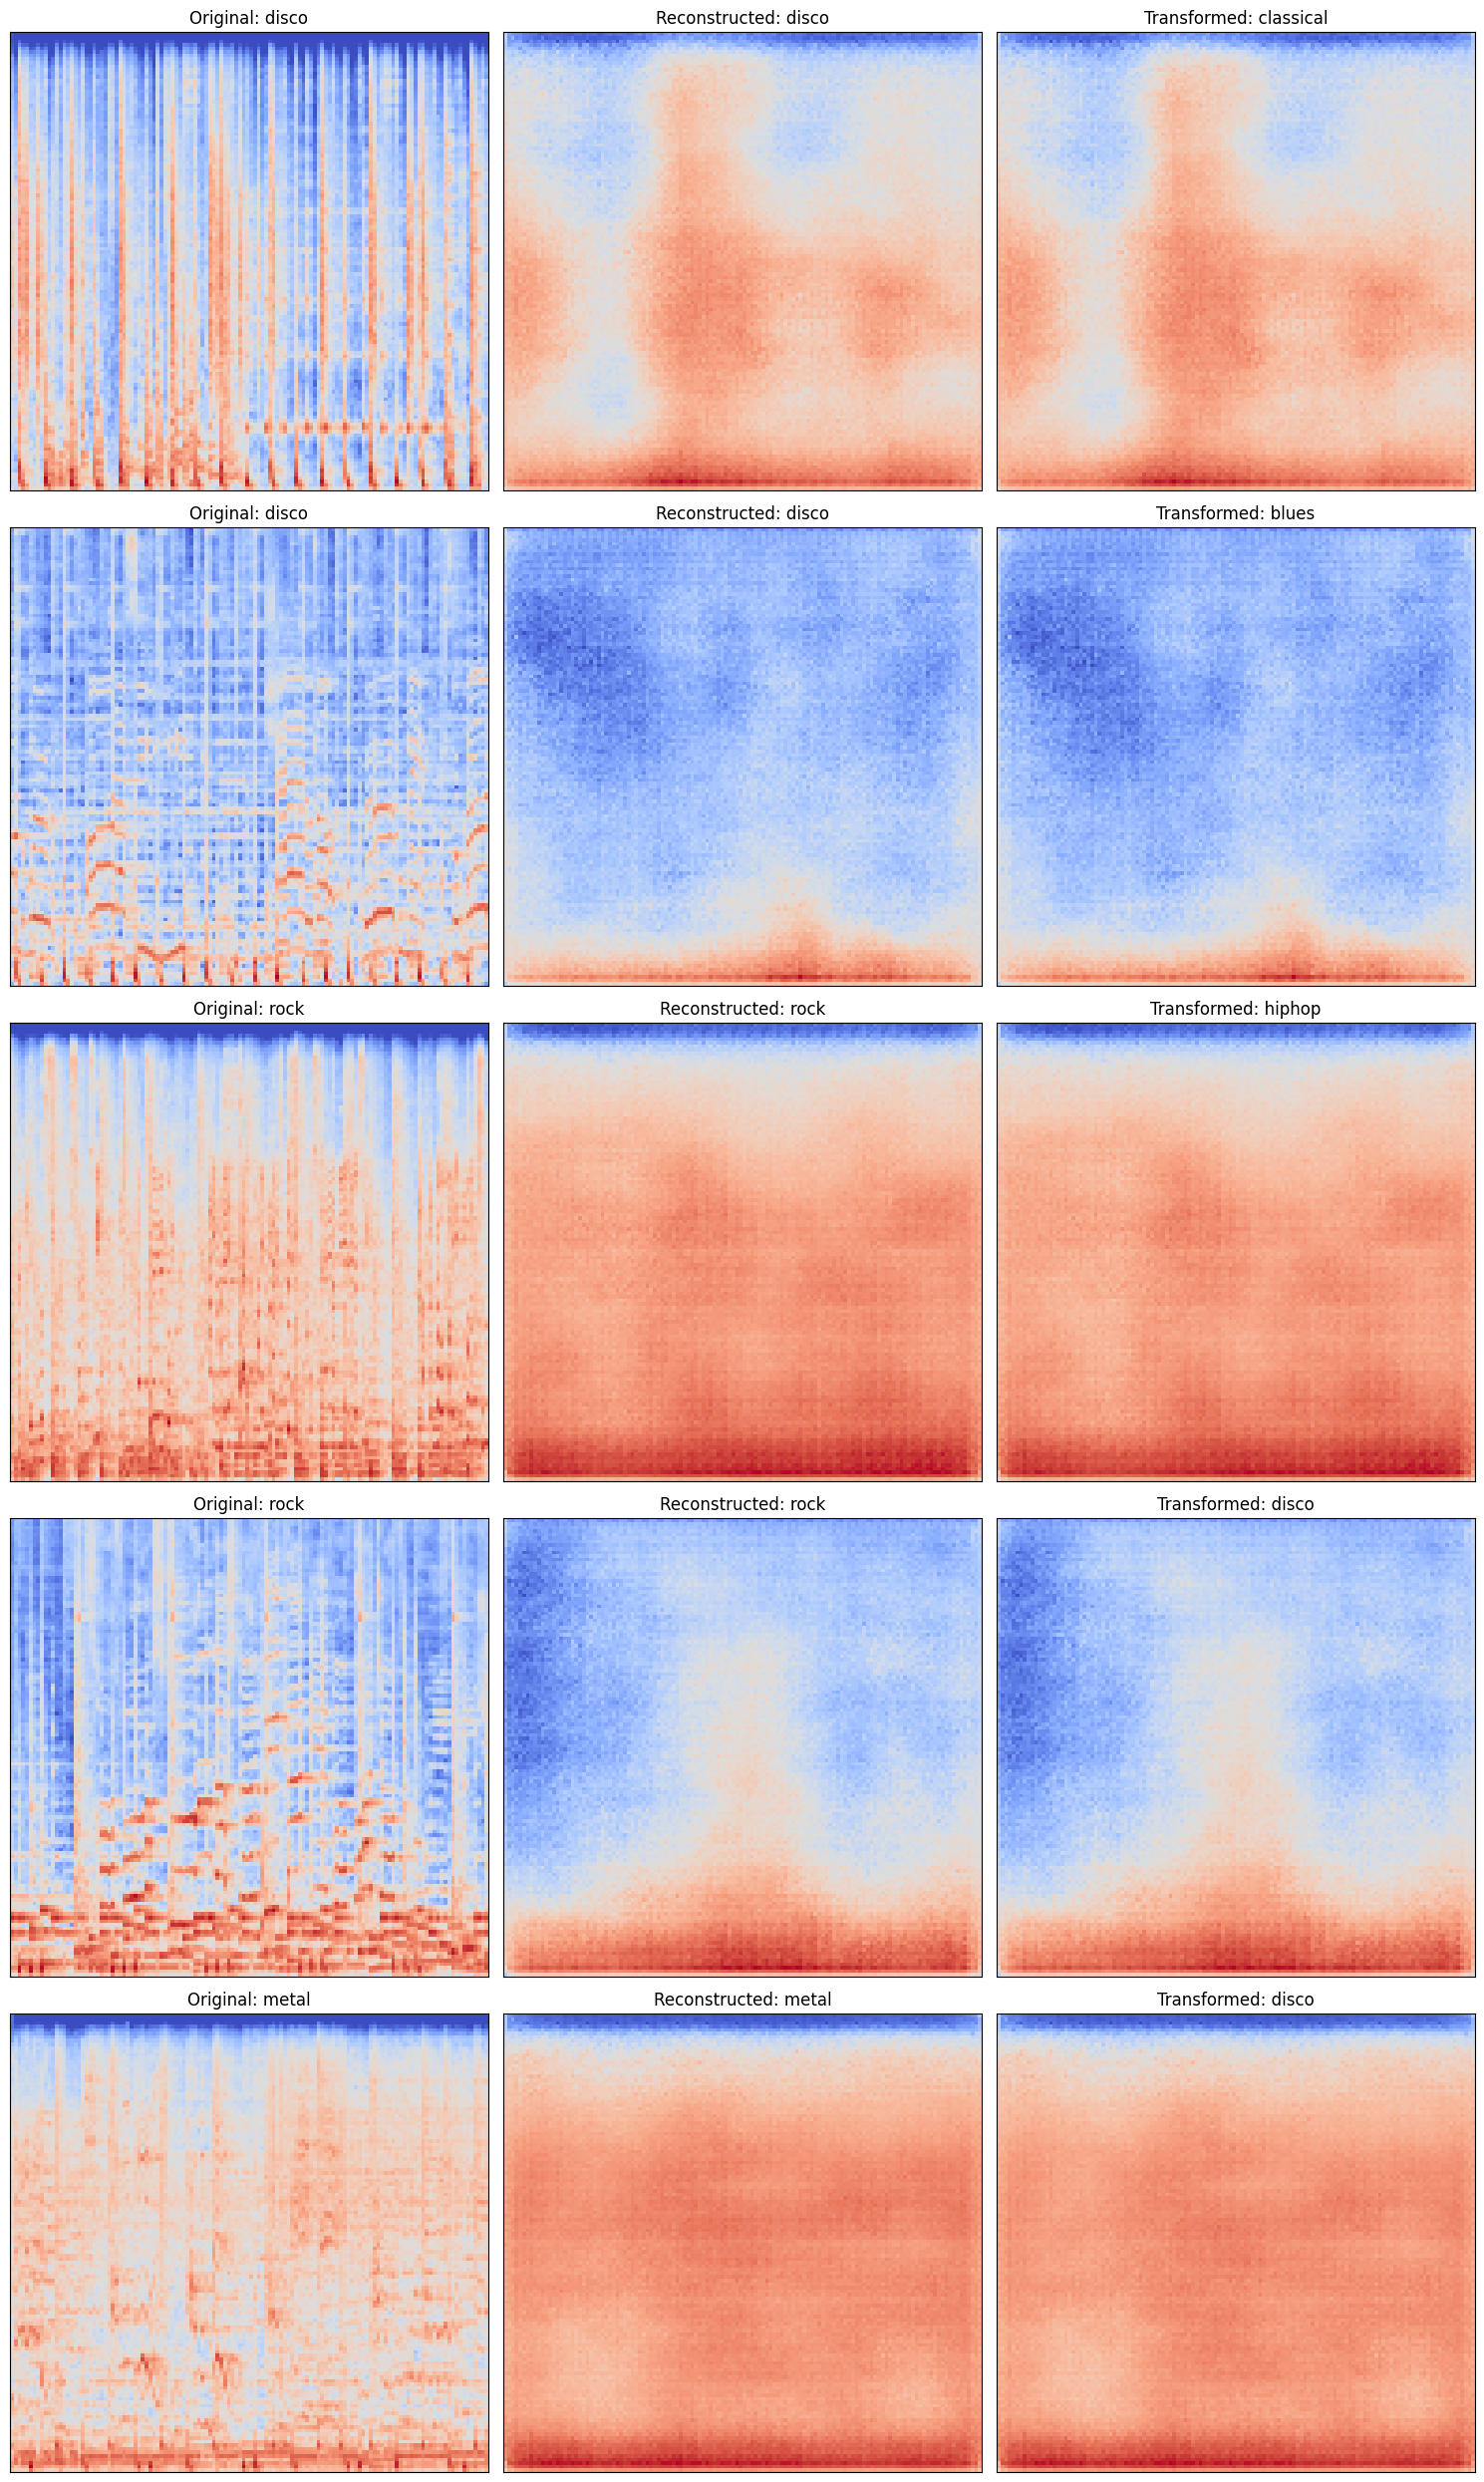


Generating audio examples...


In [ ]:

class WaveGANDiscriminator(nn.Module):
    """WaveGAN-inspired discriminator for raw audio"""
    def __init__(self):
        super(WaveGANDiscriminator, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=25, stride=4, padding=11)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=11)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=11)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=25, stride=4, padding=11)
        self.conv5 = nn.Conv1d(512, 1024, kernel_size=25, stride=4, padding=11)

        self.fc = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv2(x), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv3(x), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv4(x), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv5(x), 0.2)
        print(x.shape)

        # Global average pooling
        x = torch.mean(x, dim=2)

        # Fully connected layer
        x = self.fc(x)

        return x

def enhance_audio_quality(audio, sr=SAMPLE_RATE):
    """Enhance audio quality with post-processing"""
    # Apply dynamic range compression
    y_compressed = librosa.effects.preemphasis(audio)

    # Apply highpass filter to remove rumble
    y_filtered = librosa.effects.hpss(y_compressed)[0]

    # Normalize audio
    y_normalized = librosa.util.normalize(y_filtered)

    return y_normalized

# Evaluation Metrics
def calculate_metrics(original_audio, transformed_audio, sr=SAMPLE_RATE):
    """Calculate audio quality metrics"""
    from scipy.stats import pearsonr

    # Calculate RMS energy
    rms_original = np.sqrt(np.mean(original_audio**2))
    rms_transformed = np.sqrt(np.mean(transformed_audio**2))

    # Calculate spectral centroid
    cent_original = librosa.feature.spectral_centroid(y=original_audio, sr=sr).mean()
    cent_transformed = librosa.feature.spectral_centroid(y=transformed_audio, sr=sr).mean()

    # Calculate MFCCs and their correlation
    mfcc_original = librosa.feature.mfcc(y=original_audio, sr=sr, n_mfcc=13)
    mfcc_transformed = librosa.feature.mfcc(y=transformed_audio, sr=sr, n_mfcc=13)

    # Ensure same length for correlation
    min_len = min(mfcc_original.shape[1], mfcc_transformed.shape[1])
    mfcc_corr, _ = pearsonr(
        mfcc_original[:, :min_len].mean(axis=0),
        mfcc_transformed[:, :min_len].mean(axis=0)
    )

    # Calculate zero-crossing rate
    zcr_original = librosa.feature.zero_crossing_rate(original_audio).mean()
    zcr_transformed = librosa.feature.zero_crossing_rate(transformed_audio).mean()

    return {
        'rms_ratio': rms_transformed / rms_original,
        'centroid_ratio': cent_transformed / cent_original,
        'mfcc_correlation': mfcc_corr,
        'zcr_ratio': zcr_transformed / zcr_original
    }

def create_confusion_matrix(classifier, test_loader):
    """Create confusion matrix for genre classifier"""
    classifier.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for mel_specs, _, genre_idxs in tqdm(test_loader, desc='Evaluating classifier'):
            mel_specs = mel_specs.unsqueeze(1).to(device)
            genre_idxs = genre_idxs.to(device)

            # Classification
            logits = classifier(mel_specs)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(genre_idxs.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=GENRES, yticklabels=GENRES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Genre Classification Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=GENRES)
    print(report)

    return cm, report

if __name__ == "__main__":
    # Path to GTZAN dataset
    # You can download it using:
    # !wget http://opihi.cs.uvic.ca/sound/genres.tar.gz
    # !tar -xzf genres.tar.gz

    data_dir = '/content/gtzan_dataset/genres_original'  # Update this path

    # Train model
    encoder, decoder, classifier, discriminator, success_df = train_genre_transformation_model(
        data_dir,
        output_dir='model_checkpoints',
        batch_size=16,
        epochs=10
    )

    #Example transformation
    transformed_audio = transform_audio(
        'genres/blues/blues.00000.wav',  # Input audio path
        'blues',                        # Source genre
        'jazz',                         # Target genre
        encoder,
        decoder,
        'transformed_blues_to_jazz.wav' # Output path
    )

    #Play transformed audio
    from IPython.display import Audio
    display(Audio(transformed_audio, rate=SAMPLE_RATE))



In [11]:
encoder, decoder, classifier, discriminator = load_model('/content/model_checkpoints/best_model.pth')

In [16]:
#Example transformation
transformed_audio = transform_audio(
      '/content/gtzan_dataset/genres_original/blues/blues.00000.wav',  # Input audio path
      'blues',                        # Source genre
      'jazz',                         # Target genre
      encoder,
      decoder,
      'transformed_blues_to_jazz.wav' # Output path
  )

In [17]:
#Play transformed audio
from IPython.display import Audio
display(Audio(transformed_audio, rate=SAMPLE_RATE))